In [1]:
import os
import numpy as np
import cv2
from os.path import join
from glob import glob
import matplotlib.pyplot as plt
import skimage
import time
from math import sqrt
from tqdm.notebook import tqdm
from google.colab import drive
from skimage.morphology import skeletonize

In [2]:
# Google Drive 마운트
drive.mount('/content/drive')

# 이미지 경로
train_dir = '/content/drive/My Drive/train_ref'
test_dir = '/content/drive/My Drive/test2'

Mounted at /content/drive


In [3]:
def normalize_pixel(x, v0, v, m, m0):
  dev_coeff = sqrt((v0 * ((x - m)**2)) / v)
  return m0 + dev_coeff if x > m else m0 - dev_coeff

def normalize(im, m0, v0):
    m = np.mean(im)
    v = np.std(im) ** 2
    (y, x) = im.shape
    normilize_image = im.copy()
    for i in range(x):
        for j in range(y):
            normilize_image[j, i] = normalize_pixel(im[j, i], v0, v, m, m0)

    return normilize_image

In [4]:
train_images = [os.path.join(train_dir, f) for f in os.listdir(train_dir) if f.endswith('.BMP')]
test_images = [os.path.join(test_dir, f) for f in os.listdir(test_dir) if f.endswith('.BMP')]

In [5]:
#이미지의 각 픽셀 값에서 평균을 빼고, 표준 편차로 나누어 정규화하는 함수
def normalise(img):
    return (img-np.mean(img))/(np.std(img))

🔽 segmentation 분할


In [6]:
def segmentation(im, w=4, threshold=.2):
    (y, x) = im.shape
    threshold = np.std(im)*threshold

    image_variance = np.zeros(im.shape)
    segmented_image = im.copy()
    mask = np.ones_like(im)

    #w*w 블록 단위로 표준 편차 계산
    for i in range(0, x, w):
        for j in range(0, y, w):
            box = [i, j, min(i + w, x), min(j + w, y)]
            block_stddev = np.std(im[box[1]:box[3], box[0]:box[2]])
            image_variance[box[1]:box[3], box[0]:box[2]] = block_stddev

    # 임계값 적용
    mask[image_variance < threshold] = 0

    # smooth mask with a open/close morphological filter
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(w*2, w*2))
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    # 이미지 정규화
    segmented_image *= mask

    return segmented_image

🔽 이진화 Binarization; threshold

In [7]:
def binarization(img):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #gray scale로 변환
  img = cv2.resize(img, (256, 256))  # 크기 조정
  img = cv2.GaussianBlur(img, (5, 5), 0)


  binary_image = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 11, 2)
  return binary_image


🔽 작은 개체 제거

In [8]:
def remove_small_objects(img, min_size):
    # Find all connected components (white blobs in binary image)
    nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(img, connectivity=8)
    sizes = stats[1:, -1]

    # Initialize the output image with all zeros (black)
    img2 = np.zeros((output.shape), dtype=np.uint8)

    # For every component in the image, you keep it only if it's above min_size
    for i in range(0, nb_components - 1):
        if sizes[i] >= min_size:
            img2[output == i + 1] = 255

    return img2

🔽 세션화 skeletonization

In [9]:
def thinning_morph(image, kernel):
    #image = remove_small_objects(image, min_size=50)

    thining_image = np.zeros_like(image)
    img = image.copy()

    while 1:
        erosion = cv2.erode(img, kernel, iterations = 1) #침식, 객체 축소
        dilatate = cv2.dilate(erosion, kernel, iterations = 1) #팽창, 객체 확장

        subs_img = np.subtract(img, dilatate) #팽창된 이미지와 차이 계산
        cv2.bitwise_or(thining_image, subs_img, thining_image) #subs_img를 thining_image (0 행렬)에 병합
        img = erosion.copy() #img = 침식 이미지로 update

        done = (np.sum(img) == 0) #img 합이 0이 되면 종료

        if done:
          break

    # thining_image를 한 픽셀 아래로 이동
    down = np.zeros_like(thining_image)
    down[1:-1, :] = thining_image[0:-2, ]
    down_mask = np.subtract(down, thining_image)
    down_mask[0:-2, :] = down_mask[1:-1, ]
    #cv.imshow('down', down_mask)

    # thining_image를 한 픽셀 오른쪽으로 이동
    left = np.zeros_like(thining_image)
    left[:, 1:-1] = thining_image[:, 0:-2]
    left_mask = np.subtract(left, thining_image)
    left_mask[:, 0:-2] = left_mask[:, 1:-1]
    #cv.imshow('left', left_mask)

    # 각 마스크 생성 후 결합하여 thining image 생성
    cv2.bitwise_or(down_mask, down_mask, thining_image)
    output = np.zeros_like(thining_image)
    output[thining_image < 250] = 255

    return output

In [10]:
def preprocess_image_display(image_path):
    image = cv2.imread(image_path)
    binary_image = binarization(image) #이진화
    segmented_image = segmentation(binary_image) #segmentation

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3)) #3*3 타원형 커널
    output = thinning_morph(segmented_image,kernel) #세션화

    # Display images
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.title('Original Image')
    plt.imshow(image)
    plt.subplot(1, 3, 2)
    plt.title('Bianry Image')
    plt.imshow(cv2.cvtColor(binary_image, cv2.COLOR_GRAY2RGB))
    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(output,cv2.COLOR_GRAY2RGB))
    plt.title('Skeletonized Image')
    plt.show()

    return  output


In [11]:
def preprocess_image(image_path):
  image = cv2.imread(image_path)
  binary_image = binarization(image)
  # 이진화
  segmented_image = segmentation(binary_image)
  kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))

  output = thinning_morph(segmented_image,kernel)


  return  output


In [12]:
def minutiae_at(pixels, i, j, kernel_size):
    #crossing number 방법을 사용해서 end와 bif를 찾는다.

    # 가운데 픽셀이 검정색이라면
    if pixels[i][j] == 1:
        #주변 픽셀 위치
        cells = [(-1, -1), (-1, 0), (-1, 1),        # p1 p2 p3
                (0, 1),  (1, 1),  (1, 0),            # p8    p4
                (1, -1), (0, -1), (-1, -1)]           # p7 p6 p5
        #주변 픽셀 값 저장
        values = [pixels[i + l][j + k] for k, l in cells]

        # 0에서 1로 또는 1에서 0으로의 변화를 계산
        crossings = 0
        for k in range(0, len(values)-1):
            crossings += abs(values[k] - values[k + 1])
        crossings //= 2

        # 교차 수가 1이면 end point
        # 교차 수가 3이면 bifurcation point
        if crossings == 1:
            return "ending"
        if crossings == 3:
            return "bifurcation"

    return "none"


def calculate_minutiaes(img, kernel_size=3):
    biniry_image = np.zeros_like(img)
    biniry_image[img<10] = 1.0
    biniry_image = biniry_image.astype(np.int8)

    (y, x) = img.shape
    result = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    colors = {"ending" : (255, 0, 0), "bifurcation" : (0, 0, 255)}

    # iterate each pixel minutia
    for i in range(kernel_size//2, x - kernel_size//2):
        for j in range(kernel_size//2, y - kernel_size//2):
            # ROI 바깥 영역인 경우 무시
            #if mask[j,i]==0
                #continue
            minutiae = minutiae_at(biniry_image, j, i, kernel_size)
            if minutiae != "none":
                cv2.circle(result, (i,j), radius=2, color=colors[minutiae], thickness=-2)

    return result

In [13]:
img = preprocess_image(test_images[1])

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]], dtype=uint8)
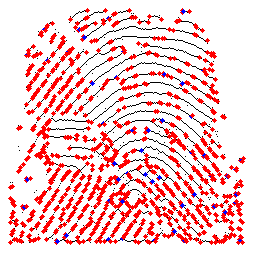

In [14]:
calculate_minutiaes(img)

In [15]:
def extract_minutiae_points(img, kernel_size=3):
    biniry_image = np.zeros_like(img)
    biniry_image[img < 10] = 1.0
    biniry_image = biniry_image.astype(np.int8)

    (y, x) = img.shape
    minutiae_points = {"ending": [], "bifurcation": []}

    for i in range(kernel_size//2, x - kernel_size//2):
        for j in range(kernel_size//2, y - kernel_size//2):
            minutiae = minutiae_at(biniry_image, j, i, kernel_size)
            if minutiae != "none":
                minutiae_points[minutiae].append((i, j))

    return minutiae_points

In [16]:
p_test_images = []
for image_path in tqdm(test_images):
  preprocessed_image = preprocess_image(image_path)
  p_test_images.append(preprocessed_image)

  0%|          | 0/1428 [00:00<?, ?it/s]

In [17]:
p_train_images = []
for image_path in tqdm(train_images):
  preprocessed_image = preprocess_image(image_path)
  p_train_images.append(preprocessed_image)

  0%|          | 0/477 [00:00<?, ?it/s]

In [18]:
test_minutiaes = []
for test_image in tqdm(p_test_images):
  test_minutiae = extract_minutiae_points(test_image)
  test_minutiaes.append(test_minutiae)

  0%|          | 0/1428 [00:00<?, ?it/s]

In [19]:
train_minutiaes = []
for train_image in tqdm(p_train_images):
  train_minutiae = extract_minutiae_points(train_image)
  train_minutiaes.append(train_minutiae)

  0%|          | 0/477 [00:00<?, ?it/s]

In [20]:
# 좌표 값들의 l2 norm distance 구하기
def l2_norm_distance(points1, points2):
    if not points1 or not points2:
        return float('inf')
    points1 = np.array(points1)
    points2 = np.array(points2)
    dists = np.linalg.norm(points1[:, np.newaxis] - points2, axis=2)
    return np.mean(np.min(dists, axis=1))

def precompute_distances(test_minutiae, train_minutiaes):
    distances = []
    for idx, train_minutiae in enumerate(train_minutiaes):
        distance = 0
        if test_minutiae["ending"] and train_minutiae["ending"]:
            distance += l2_norm_distance(test_minutiae["ending"], train_minutiae["ending"])
        if test_minutiae["bifurcation"] and train_minutiae["bifurcation"]:
            distance += l2_norm_distance(test_minutiae["bifurcation"], train_minutiae["bifurcation"])

        #print(f'{idx}: distance {distance}')

        distances.append(distance)
    return distances

def match_fingerprints(test_minutiae, train_minutiaes, kernel_size=3):
    precomputed_distances = precompute_distances(test_minutiae, train_minutiaes)
    best_match = np.argmin(precomputed_distances)
    min_distance = precomputed_distances[best_match]

    return best_match, min_distance, precomputed_distances


In [21]:
best_match_idx, min_distance, distances = match_fingerprints(test_minutiaes[0], train_minutiaes)

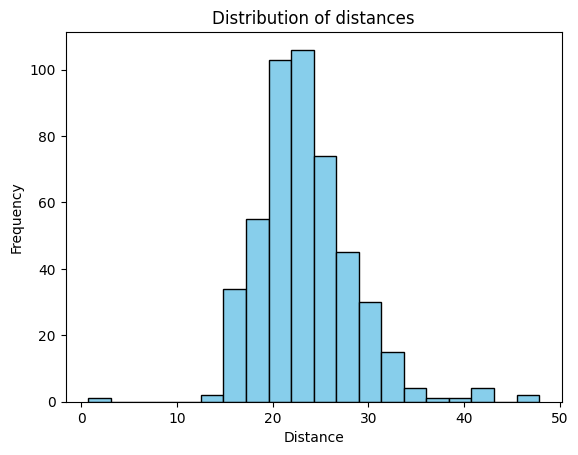

In [22]:
import matplotlib.pyplot as plt

# 거리 분포 히스토그램
plt.hist(distances, bins=20, color='skyblue', edgecolor='black')

plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.title('Distribution of distances')

plt.show()


In [23]:
# Match test image with train images
for idx, test_minutiae in tqdm(enumerate(test_minutiaes)):
    best_match_idx, min_dist, distances = match_fingerprints(test_minutiae, train_minutiaes)
    test_image_name = test_images[idx].split("/")[-1].split(".")[0]
    train_image_name = train_images[best_match_idx].split("/")[-1].split(".")[0]
    print(f'Best match: Test image: {test_image_name} Train image {train_image_name} with distance {min_dist}')


0it [00:00, ?it/s]

Best match: Test image: 513_type3 Train image 513 with distance 0.7469495051005892
Best match: Test image: 403_type1 Train image 403 with distance 0.7146609355178761
Best match: Test image: 380_type3 Train image 380 with distance 1.6027494768544903
Best match: Test image: 124_type2 Train image 124 with distance 5.315643182356579
Best match: Test image: 6_type1 Train image 6 with distance 2.3197883461890054
Best match: Test image: 290_type1 Train image 290 with distance 3.583037719680733
Best match: Test image: 129_type1 Train image 129 with distance 8.185032572478217
Best match: Test image: 38_type1 Train image 38 with distance 1.5090811869670278
Best match: Test image: 306_type2 Train image 306 with distance 3.064079598455881
Best match: Test image: 595_type2 Train image 595 with distance 2.394957543195477
Best match: Test image: 254_type2 Train image 254 with distance 2.657601650158261
Best match: Test image: 312_type2 Train image 312 with distance 2.147906924987278
Best match: Test 

KeyboardInterrupt: 

In [24]:
def match_fingerprints(test_image, train_images):
    best_match = None
    best_score = float('inf')
    test_image = np.array(test_image)
    for idx, train_image in enumerate(train_images):
        #train_image = np.array(train_image)
        if test_image.shape == train_image.shape:
            score = np.sum((test_image.astype("float") - train_image.astype("float")) ** 2)
            if score < best_score:
                best_score = score
                best_match = idx
    return best_match, best_score


In [25]:
matches = {}
distances = {}

for idx, test_image in enumerate(p_test_images):
    best_match, best_distance = match_fingerprints(test_image, p_train_images)
    test_name = test_images[idx].split("/")[-1].split(".")[0]
    train_name = train_images[best_match].split("/")[-1].split(".")[0]

    matches[test_name] = train_name
    distances[test_name] = best_distance

    print(f"Best match for { test_name}: {train_name} with distance {best_distance}")


Best match for 513_type3: 513 with distance 24124275.0
Best match for 403_type1: 403 with distance 49288950.0
Best match for 380_type3: 380 with distance 30691800.0
Best match for 124_type2: 124 with distance 123937650.0
Best match for 6_type1: 6 with distance 56961900.0
Best match for 290_type1: 290 with distance 64959975.0
Best match for 129_type1: 129 with distance 57807225.0
Best match for 38_type1: 38 with distance 58262400.0
Best match for 306_type2: 306 with distance 55856475.0
Best match for 595_type2: 595 with distance 68016150.0
Best match for 254_type2: 254 with distance 51629850.0
Best match for 312_type2: 312 with distance 52085025.0
Best match for 259_type1: 259 with distance 53840700.0
Best match for 349_type3: 349 with distance 30366675.0
Best match for 365_type3: 365 with distance 31407075.0
Best match for 105_type3: 105 with distance 17946900.0
Best match for 365_type1: 365 with distance 58847625.0
Best match for 223_type1: 223 with distance 38234700.0
Best match for 

In [ ]:
import matplotlib.pyplot as plt

# 거리 분포 히스토그램
plt.hist(matches, bins=10000, color='skyblue', edgecolor='black')

plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.title('Distribution of distances')

plt.show()


In [26]:
# Calculate metrics
true_positives = 0
false_positives = 0
false_negatives = 0
true_negatives = 0
total_tests = len(p_test_images)

for test_name in matches:
    test_image_number = test_name.split("_")[0]
    matched_image_number = matches[test_name].split(".")[0]

    if test_image_number == matched_image_number:
        if "type" in test_name:
            true_positives += 1
        else:
            true_negatives += 1
    else:
        if "type" in test_name:
            false_negatives += 1
        else:
            false_positives += 1

precision = true_positives / (true_positives + false_positives) if true_positives + false_positives > 0 else 0
recall = true_positives / (true_positives + false_negatives) if true_positives + false_negatives > 0 else 0
far = false_positives / total_tests if total_tests > 0 else 0
frr = false_negatives / total_tests if total_tests > 0 else 0
acc = (true_positives + true_negatives) / total_tests if total_tests > 0 else 0

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"FAR: {far}")
print(f"FRR: {frr}")
print(f"Accuracy: {acc}")

Precision: 1.0
Recall: 1.0
FAR: 0.0
FRR: 0.0
Accuracy: 1.0
